In [1]:
import file_reader as fr
import itertools as it
import pandas as pd
from sklearn.linear_model import LogisticRegression, LassoCV, RidgeCV, ElasticNetCV, SGDClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

%matplotlib inline

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
ephys_data = fr.get_ephys_data()

In [3]:
gamble_choices = fr.get_gamble_choices_data()

In [4]:
behavior_data = fr.get_behavior_data()

C:\Users\MariLiis\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
regressor_data = fr.get_regressor_data()

In [6]:
SUBJECTS = ["s1", "s2", "s3", "s4", "s5", "s6", "s7", "s8", "s9", "s10"]

In [7]:
gamble_choices.head()

,Safe.Bet.Amount,Risky.Bet.Amount,Risky.bet.shown.number,Risky.bet.hidden.number,Risky.Side
0,10,30,1,5,Left
1,10,20,4,5,Left
2,10,25,7,8,Right
3,10,30,1,4,Left
4,10,25,6,1,Left


In [8]:
sub1_ephys = ephys_data["s1"]
sub1_behavior = behavior_data["s1"]
sub1_behavior.head()

,round,newround.time,choice.time,buttonpress.time,conf.time,reveal.time,choice.location,choice.class,outcome,trial.included
0,1,6.191,6.957,8.003,8.019,8.535,Left,Gamble,Win,1
1,2,9.550,10.316,11.441,11.457,11.972,Left,Gamble,Win,1
2,3,12.988,13.753,14.832,14.847,15.363,Left,Safebet,WouldHaveWon,1
3,4,16.378,17.144,18.144,18.175,18.691,Left,Gamble,Win,1
4,5,19.707,20.472,21.519,21.550,22.066,Right,Safebet,WouldHaveLost,1


In [9]:
df = pd.concat([sub1_behavior, gamble_choices[["Risky.Bet.Amount", "Risky.bet.shown.number"]]], axis=1)
df.head()

,round,newround.time,choice.time,buttonpress.time,conf.time,reveal.time,choice.location,choice.class,outcome,trial.included,Risky.Bet.Amount,Risky.bet.shown.number
0,1,6.191,6.957,8.003,8.019,8.535,Left,Gamble,Win,1,30,1
1,2,9.550,10.316,11.441,11.457,11.972,Left,Gamble,Win,1,20,4
2,3,12.988,13.753,14.832,14.847,15.363,Left,Safebet,WouldHaveWon,1,25,7
3,4,16.378,17.144,18.144,18.175,18.691,Left,Gamble,Win,1,30,1
4,5,19.707,20.472,21.519,21.550,22.066,Right,Safebet,WouldHaveLost,1,25,6


In [10]:
df['choice.class'].value_counts()

Gamble     124
Safebet     72
Timeout      4
Name: choice.class, dtype: int64

In [11]:
X = df[df['choice.class'] != 'Timeout'][['Risky.Bet.Amount', 'Risky.bet.shown.number']]
X.head()

,Risky.Bet.Amount,Risky.bet.shown.number
0,30,1
1,20,4
2,25,7
3,30,1
4,25,6


In [12]:
X_norm = (X - X.mean()) / (X.max() - X.min())
X_norm.head()

,Risky.Bet.Amount,Risky.bet.shown.number
0,0.505102,-0.383163
1,-0.161565,-0.083163
2,0.171769,0.216837
3,0.505102,-0.383163
4,0.171769,0.116837


In [13]:
df = X['Risky.Bet.Amount']
df_norm = (df - df.mean()) / (df.max() - df.min())

In [14]:
sub1_behavior[sub1_behavior['choice.class'] == 'Timeout']

,round,newround.time,choice.time,buttonpress.time,conf.time,reveal.time,choice.location,choice.class,outcome,trial.included
11,12,44.832,45.597,NaN,47.613,48.128,Timeout,Timeout,Timeout,0
15,16,60.597,61.363,NaN,63.378,63.894,Timeout,Timeout,Timeout,0
110,111,402.800,403.566,NaN,405.582,406.097,Timeout,Timeout,Timeout,0
156,157,562.253,563.019,NaN,565.035,565.550,Timeout,Timeout,Timeout,0


In [15]:
idx = sub1_behavior[sub1_behavior['choice.class'] == 'Timeout'].index
idx

Int64Index([11, 15, 110, 156], dtype='int64')

In [16]:
sub1_behavior.iloc[idx]

,round,newround.time,choice.time,buttonpress.time,conf.time,reveal.time,choice.location,choice.class,outcome,trial.included
11,12,44.832,45.597,NaN,47.613,48.128,Timeout,Timeout,Timeout,0
15,16,60.597,61.363,NaN,63.378,63.894,Timeout,Timeout,Timeout,0
110,111,402.800,403.566,NaN,405.582,406.097,Timeout,Timeout,Timeout,0
156,157,562.253,563.019,NaN,565.035,565.550,Timeout,Timeout,Timeout,0


In [17]:
def make_data(subjects=SUBJECTS):
    data = {}
    for s in subjects:
        behav = behavior_data[s]
        non_timeout_idx = behav[behav['choice.class'] != 'Timeout'].index
        X = gamble_choices.iloc[non_timeout_idx][['Risky.Bet.Amount', 'Risky.bet.shown.number']]
        y = behav.iloc[non_timeout_idx]['choice.class'].replace('Gamble', 1).replace('Safebet', 0)
        X = X.reset_index(drop=True)
        y = y.reset_index(drop=True)
        data[s] = (X, y)
    return data

In [18]:
def make_normalized_data(subjects=SUBJECTS):
    data = {}
    for s in subjects:
        behav = behavior_data[s]
        non_timeout_idx = behav[behav['choice.class'] != 'Timeout'].index
        X = gamble_choices.iloc[non_timeout_idx][['Risky.Bet.Amount', 'Risky.bet.shown.number']]
        y = behav.iloc[non_timeout_idx]['choice.class'].replace('Gamble', 1).replace('Safebet', 0)
        X = X.reset_index(drop=True)
        y = y.reset_index(drop=True)
        X_norm = (X - X.mean()) / (X.max() - X.min()) # normalize data
        data[s] = (X_norm, y)
    return data

In [19]:
data = make_data()

In [20]:
data_norm = make_normalized_data()

In [21]:
data['s1'][0].head()

,Risky.Bet.Amount,Risky.bet.shown.number
0,30,1
1,20,4
2,25,7
3,30,1
4,25,6


In [22]:
data_norm['s1'][0].head()

,Risky.Bet.Amount,Risky.bet.shown.number
0,0.505102,-0.383163
1,-0.161565,-0.083163
2,0.171769,0.216837
3,0.505102,-0.383163
4,0.171769,0.116837


In [23]:
X, y = data['s9']
logr = LogisticRegression()
print("LogisticRegression", cross_val_score(logr, X, y, cv=5)) 
lasso = LassoCV()
print("LassoCV", cross_val_score(lasso, X, y, cv=5)) 
ridge = RidgeCV()
print("RidgeCV", cross_val_score(ridge, X, y, cv=5)) 
linsvc = LinearSVC()
print("LinearSVC", cross_val_score(linsvc, X, y, cv=5))
nusvc = NuSVC()
print("NuSVC", cross_val_score(nusvc, X, y, cv=5))
svc = SVC()
print("SVC", cross_val_score(svc, X, y, cv=5))
dt = DecisionTreeClassifier()
print("DecisionTreeClassifier", cross_val_score(dt, X, y, cv=5))
edt = ExtraTreeClassifier()
print("ExtraTreeClassifier", cross_val_score(edt, X, y, cv=5))
rf = RandomForestClassifier()
print("RandomForestClassifier", cross_val_score(rf, X, y, cv=5))
enet = ElasticNetCV()
print("ElasticNetCV", cross_val_score(enet, X, y, cv=5))
sgd = SGDClassifier()
print("SGDClassifier", cross_val_score(sgd, X, y, cv=5))

LogisticRegression [0.85  0.75  0.7   0.925 0.85 ]
LassoCV [0.58823906 0.48156191 0.27773411 0.63145393 0.59726858]
RidgeCV [0.58790851 0.4817875  0.27912191 0.63098886 0.59660411]
LinearSVC [0.925 0.75  0.75  0.975 0.85 ]
NuSVC [0.9   0.825 0.7   0.975 0.875]
SVC [0.9   0.825 0.7   0.975 0.875]
DecisionTreeClassifier [0.9  0.8  0.7  0.95 0.85]
ExtraTreeClassifier [0.9  0.8  0.7  0.95 0.85]
RandomForestClassifier [0.925 0.85  0.7   0.95  0.9  ]
ElasticNetCV [0.58823285 0.48156661 0.27784843 0.63144598 0.59718059]
SGDClassifier [0.8   0.725 0.7   0.8   0.85 ]


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\MariLiis\Anaconda

In [24]:
LR = "LogisticRegression"
LASSO = "LassoCV"
RIDGE = "RidgeCV"
LSVC = "LinearSVC"
NUSVC = "NuSVC"
SVC = "SVC"
ELNET = "ElasticNetCV"
SGD = "SGDClassifier"
MODELS = [LR, LASSO, RIDGE, LSVC, NUSVC, SVC, ELNET, SGD]

In [25]:
np.array([[1,2], [3,4]]).mean(axis=0)

A = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
b = np.array([1, 2, 3, 4])
kf = KFold(n_splits=4)
for i1, i2 in kf.split(A):
    print(i1, i2)

[1 2 3] [0]
[0 2 3] [1]
[0 1 3] [2]
[0 1 2] [3]


In [26]:
def cross_validation(X, y, model, k=5):
    test_accuracies = []
    train_accuracies = []
    X_weights = []
    kf = KFold(n_splits=k)
    
    for idx_tr, idx_te in kf.split(X):
        X_train = X.iloc[idx_tr]
        y_train = y.iloc[idx_tr]
        
        X_test = X.iloc[idx_te]
        y_test = y.iloc[idx_te]
        
        if model == LR:
            logr = LogisticRegression()
            logr.fit(X_train, y_train)
            test_accuracies.append(logr.score(X_test, y_test))
            train_accuracies.append(logr.score(X_train, y_train))
            X_weights.append(logr.coef_)
        
        elif model == LSVC:
            lsvc = LinearSVC()
            lsvc.fit(X_train, y_train)
            test_accuracies.append(lsvc.score(X_test, y_test))
            train_accuracies.append(lsvc.score(X_train, y_train))
            X_weights.append(lsvc.coef_)
        
        elif model == NUSVC:
            nusvc = NuSVC()
            nusvc.fit(X_train, y_train)
            test_accuracies.append(nusvc.score(X_test, y_test))
            train_accuracies.append(nusvc.score(X_train, y_train))
#             X_weights.append(nusvc.coef_)  # coef_ only available with a linear kernel
    
    mean_test = round(np.array(test_accuracies).mean(), 3)
    mean_train = round(np.array(train_accuracies).mean(), 3)
    
    return np.array(X_weights).mean(axis=0)[0], mean_test, mean_train

In [27]:
def test_models(data, models):
    results = defaultdict(dict)
    for m in models:
        mean_coefs = []
        test_accs = []
        train_accs = []
        for s in SUBJECTS:
            X, y = data[s]
            print("Subject", s)
            coefs, mean_test, mean_train = cross_validation(X, y, m)
            mean_coefs.append(coefs)
            test_accs.append(mean_test)
            train_accs.append(mean_train)
            print("Model %s, mean test acc %f, train acc %f" % (m, mean_test, mean_train))
            
        results[m]["mean_coefs"] = mean_coefs
        results[m]["test_accs"] = test_accs
        results[m]["train_accs"] = train_accs

    return results

In [28]:
results = test_models(data, [LR, LSVC])

Subject s1
Model LogisticRegression, mean test acc 0.786000, train acc 0.782000
Subject s2
Model LogisticRegression, mean test acc 0.879000, train acc 0.893000
Subject s3
Model LogisticRegression, mean test acc 0.690000, train acc 0.696000
Subject s4
Model LogisticRegression, mean test acc 0.389000, train acc 0.532000
Subject s5
Model LogisticRegression, mean test acc 0.699000, train acc 0.739000
Subject s6
Model LogisticRegression, mean test acc 0.895000, train acc 0.895000
Subject s7
Model LogisticRegression, mean test acc 0.865000, train acc 0.876000
Subject s8
Model LogisticRegression, mean test acc 0.680000, train acc 0.691000
Subject s9
Model LogisticRegression, mean test acc 0.805000, train acc 0.825000
Subject s10
Model LogisticRegression, mean test acc 0.529000, train acc 0.600000
Subject s1
Model LinearSVC, mean test acc 0.730000, train acc 0.776000
Subject s2
Model LinearSVC, mean test acc 0.904000, train acc 0.905000
Subject s3
Model LinearSVC, mean test acc 0.670000, train

In [29]:
results_norm = test_models(data_norm, [LR, LSVC])

Subject s1
Model LogisticRegression, mean test acc 0.791000, train acc 0.804000
Subject s2
Model LogisticRegression, mean test acc 0.919000, train acc 0.919000
Subject s3
Model LogisticRegression, mean test acc 0.670000, train acc 0.705000
Subject s4
Model LogisticRegression, mean test acc 0.417000, train acc 0.556000
Subject s5
Model LogisticRegression, mean test acc 0.724000, train acc 0.737000
Subject s6
Model LogisticRegression, mean test acc 0.915000, train acc 0.921000
Subject s7
Model LogisticRegression, mean test acc 0.905000, train acc 0.908000
Subject s8
Model LogisticRegression, mean test acc 0.675000, train acc 0.706000
Subject s9
Model LogisticRegression, mean test acc 0.835000, train acc 0.834000
Subject s10
Model LogisticRegression, mean test acc 0.543000, train acc 0.600000
Subject s1
Model LinearSVC, mean test acc 0.796000, train acc 0.796000
Subject s2
Model LinearSVC, mean test acc 0.924000, train acc 0.924000
Subject s3
Model LinearSVC, mean test acc 0.680000, train

In [30]:
def plot_model_accs(results, plot_title=None):
    rows = round(len(results) / 2)
    fig, axes = plt.subplots(rows, 2, figsize=(10, 3 * rows))
    axes = axes.flatten()
    
    models = list(results.keys())
    for i in range(len(results)):
        m = models[i] # model name
        data = pd.DataFrame({"subject": SUBJECTS + SUBJECTS, "accuracy": results[m]["test_accs"] + results[m]["train_accs"], 
                                 "type": np.append(np.repeat("test", len(SUBJECTS)), np.repeat("train", len(SUBJECTS)))})
        sns.pointplot(x="subject", y="accuracy", hue="type", data=data, dodge=True, ax=axes[i]).set(
            title="%s accuracies" % m)
    
    if plot_title != None:
        fig.savefig(plot_title + ".png", bbox_inches='tight')

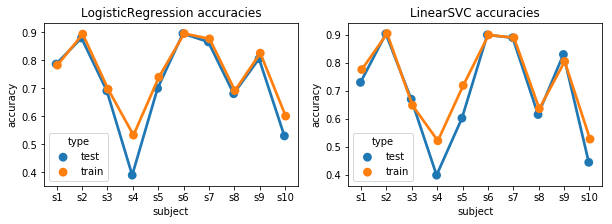

In [31]:
plot_model_accs(results, "LR_LSVC_accs")

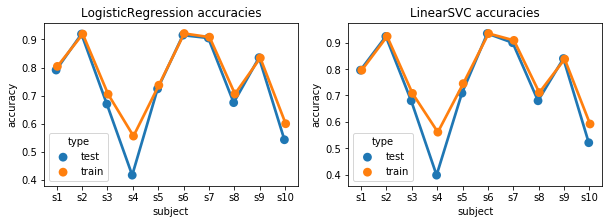

In [32]:
plot_model_accs(results_norm)

In [33]:
def plot_model_coefs(results, plot_title=None):
    rows = round(len(results) / 2)
    fig, axes = plt.subplots(rows, 2, figsize=(10, 3 * rows))
    axes = axes.flatten()
    
    models = list(results.keys())
    for i in range(len(results)):
        m = models[i] # model name

        data = pd.DataFrame({"prize_coef": np.array(results[m]["mean_coefs"])[:, 0],
                                "rnd_nr_coef": np.array(results[m]["mean_coefs"])[:, 1], 
                                "subject": SUBJECTS}) 
        sns.scatterplot(x="prize_coef", y="rnd_nr_coef", hue="subject", data=data, ax=axes[i]).set(
            title="%s coefs" % m)

        # Show only one legend 
        if i < len(results) - 1:
            axes[i].legend().remove()
        else:
            axes[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    if plot_title != None:
        fig.savefig(plot_title + ".png", bbox_inches='tight')

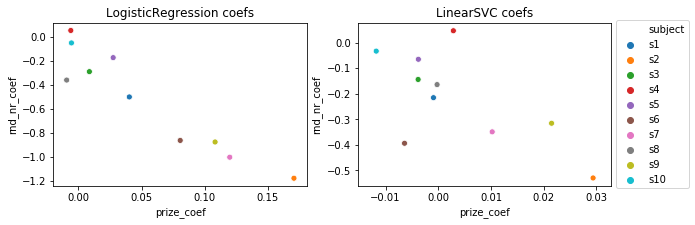

In [34]:
plot_model_coefs(results, "LR_LSVC_coefs")

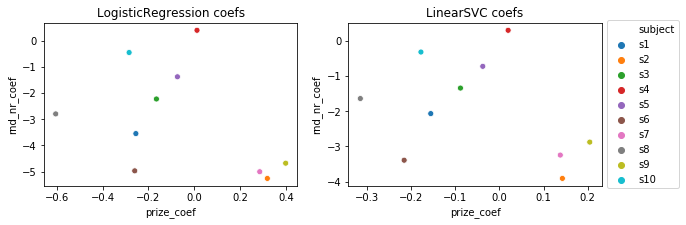

In [35]:
plot_model_coefs(results_norm)